In [8]:
import os
os.listdir(r"MURA-v1.1\train")

['XR_ELBOW',
 'XR_FINGER',
 'XR_FOREARM',
 'XR_HAND',
 'XR_HUMERUS',
 'XR_SHOULDER',
 'XR_WRIST']

In [22]:
import os
from PIL import Image
import pandas as pd


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

# Load the CSV containing image paths
csv_path = "MURA-v1.1/train_image_paths.csv"
df = pd.read_csv(csv_path, header=None, names=['image_path'])

# Extract class from the path
def extract_class(path):
    parts = path.split('/')
    body_part = parts[2]
    study_type = parts[4]
    label = study_type.split('_')[1]
    return f"{body_part} {label}"

df['class_name'] = df['image_path'].apply(extract_class)

# Show the DataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="Labeled Image Paths", dataframe=df)

df.head()
# Save the DataFrame with class names to a new CSV file
new_csv_path = "MURA-v1.1/train_image_labeled.csv"
df.to_csv(new_csv_path, index=False)

new_csv_path


,image_path,class_name
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,XR_SHOULDER positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,XR_SHOULDER positive


In [52]:
# Save the DataFrame with class names to a new CSV file
new_csv_path = "MURA-v1.1/train_image_labeled.csv"
df.to_csv(new_csv_path, index=False)

new_csv_path


'MURA-v1.1/train_image_labeled.csv'

In [54]:
csv_path = r"MURA-v1.1\train_image_labeled.csv"
df = pd.read_csv(csv_path)
df.columns


Index(['image_path', 'class_name'], dtype='object')

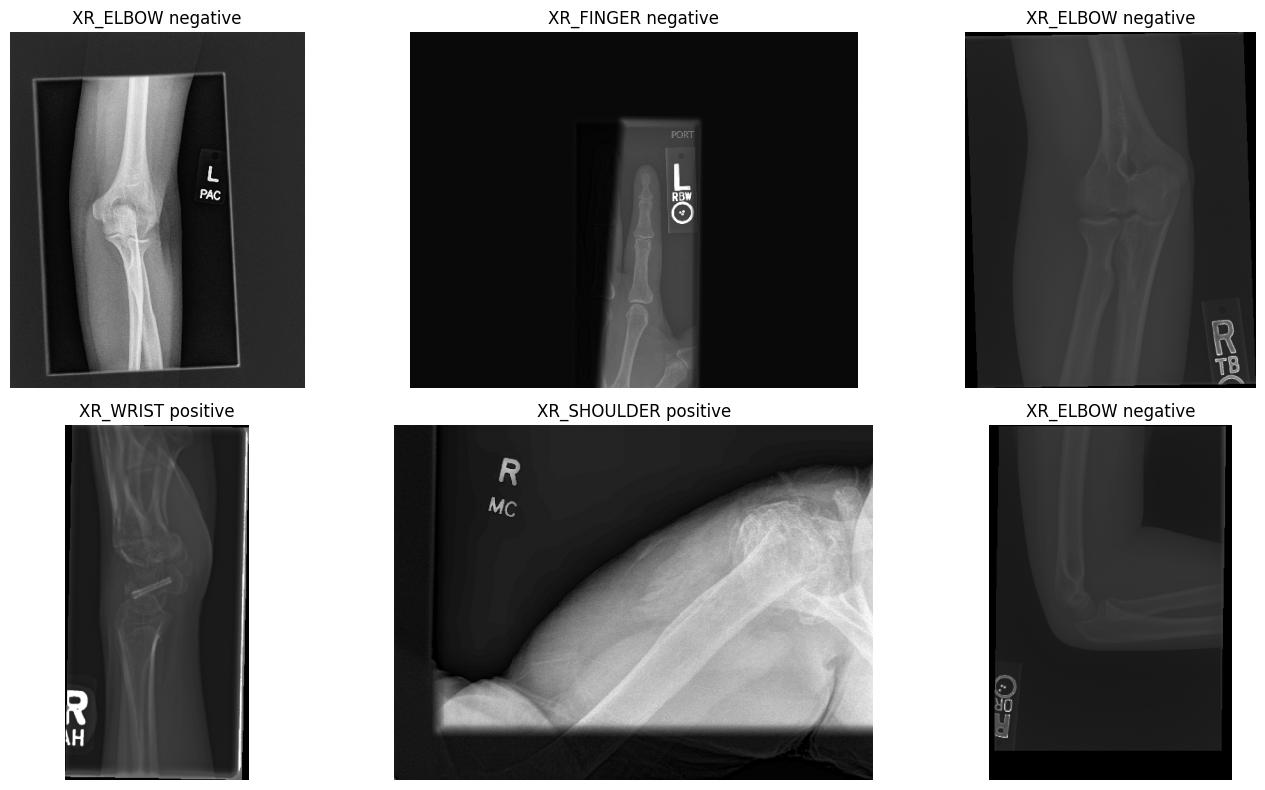

In [55]:
import random

# Select random samples from the dataframe
sampled_df = df.sample(n=6).reset_index(drop=True)

# Plot random images with class names
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, row in sampled_df.iterrows():
    image_path = row['image_path']
    class_label = row['class_name']
    
    # Check if file exists before loading
    if os.path.exists(image_path):
        image = Image.open(image_path).convert('L')  # Convert to grayscale for X-rays
        axes[idx].imshow(image, cmap='gray')
        axes[idx].set_title(class_label)
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, 'Image Not Found', ha='center', va='center')
        axes[idx].set_title("Missing Image")
        axes[idx].axis('off')

plt.tight_layout()
plt.show()


Hybrid model(Mobilenet + svm)

c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting training features to disk...
Processed 32/5600 samples
Processed 64/5600 samples
Processed 96/5600 samples
Processed 128/5600 samples
Processed 160/5600 samples
Processed 192/5600 samples
Processed 224/5600 samples
Processed 256/5600 samples
Processed 288/5600 samples
Processed 320/5600 samples
Processed 352/5600 samples
Processed 384/5600 samples
Processed 416/5600 samples
Processed 448/5600 samples
Processed 480/5600 samples
Processed 512/5600 samples
Processed 544/5600 samples
Processed 576/5600 samples
Processed 608/5600 samples
Processed 640/5600 samples
Processed 672/5600 samples
Processed 704/5600 samples
Processed 736/5600 samples
Processed 768/5600 samples
Processed 800/5600 samples
Processed 832/5600 samples
Processed 864/5600 samples
Processed 896/5600 samples
Processed 928/5600 samples
Processed 960/5600 samples
Processed 992/5600 samples
Processed 1024/5600 samples
Processed 1056/5600 samples
Processed 1088/5600 samples
Processed 1120/5600 samples
Processed 1152

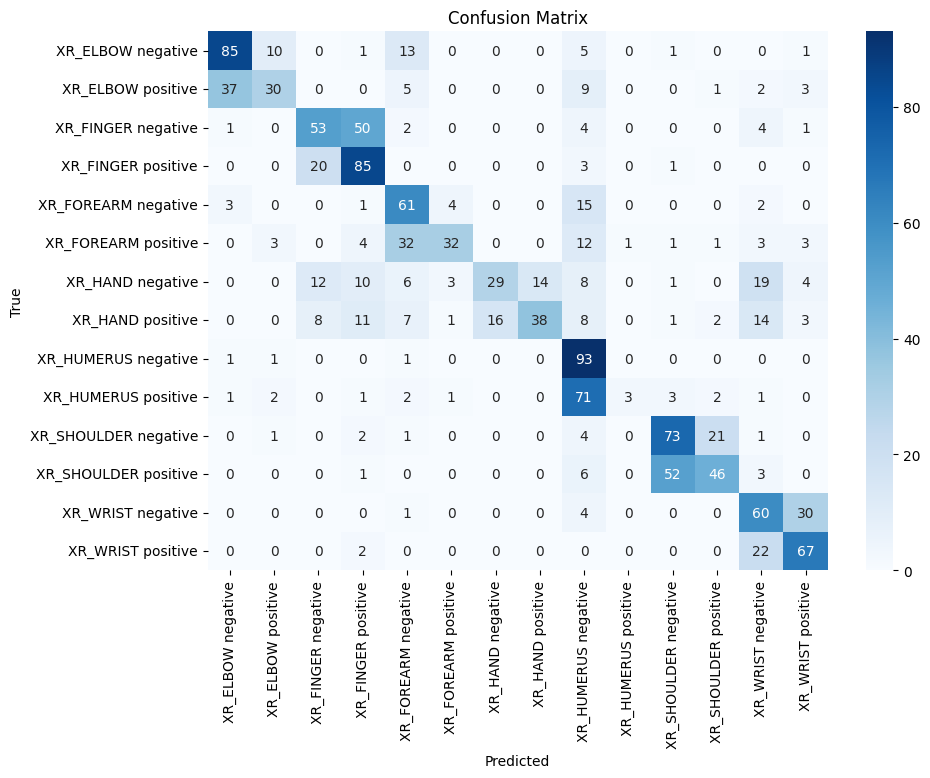

In [62]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import SGDClassifier  # Replacing SVC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import pandas as pd
import joblib
import h5py

# Base directory for the dataset
BASE_DIR = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1"
df = pd.read_csv(os.path.join(BASE_DIR, "train_image_labeled.csv"))

# Select 500 images per class
df = df.groupby('class_name').sample(n=500, random_state=42).reset_index(drop=True)

# Preprocessing for MobileNet
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, df, base_dir=BASE_DIR):
        self.df = df
        self.base_dir = base_dir
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        relative_path = self.df.iloc[idx, 0]
        image_path = os.path.join(self.base_dir, relative_path.lstrip("MURA-v1.1/"))
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = preprocess_image(image_path)
        label = self.df.iloc[idx, 1]
        return image, label

# Label Encoding
label_map = {label: idx for idx, label in enumerate(np.unique(df['class_name']))}
df['class_name'] = df['class_name'].map(label_map)
reverse_label_map = {idx: label for label, idx in label_map.items()}

# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# DataLoader
train_dataset = ImageDataset(train_df, base_dir=BASE_DIR)
val_dataset = ImageDataset(val_df, base_dir=BASE_DIR)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])
mobilenet.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet.to(device)

# Feature extraction with disk storage
def extract_features_to_disk(loader, model, output_file):
    with h5py.File(output_file, 'w') as h5f:
        num_samples = len(loader.dataset)
        feature_size = 1280 * 7 * 7
        features_dset = h5f.create_dataset('features', (num_samples, feature_size), dtype='float32')
        labels_dset = h5f.create_dataset('labels', (num_samples,), dtype='int64')
        
        start_idx = 0
        with torch.no_grad():
            for images, lbls in loader:
                images = images.to(device)
                outputs = model(images)
                outputs = outputs.view(outputs.size(0), -1).cpu().numpy()
                batch_size = outputs.shape[0]
                
                features_dset[start_idx:start_idx + batch_size] = outputs
                labels_dset[start_idx:start_idx + batch_size] = lbls.numpy()
                start_idx += batch_size
                print(f"Processed {start_idx}/{num_samples} samples")

# Extract and save features
print("Extracting training features to disk...")
train_features_file = os.path.join(BASE_DIR, "train_features.h5")
extract_features_to_disk(train_loader, mobilenet, train_features_file)

print("Extracting validation features to disk...")
val_features_file = os.path.join(BASE_DIR, "val_features.h5")
extract_features_to_disk(val_loader, mobilenet, val_features_file)

# Incremental SVM training
print("Training SVM classifier incrementally...")
svm = SGDClassifier(loss='hinge', random_state=42, max_iter=1000, tol=1e-3)  # Linear SVM via SGD

# Load and train in chunks
chunk_size = 1000  # Adjust based on available memory
with h5py.File(train_features_file, 'r') as h5f:
    num_samples = h5f['features'].shape[0]
    for start_idx in range(0, num_samples, chunk_size):
        end_idx = min(start_idx + chunk_size, num_samples)
        features_chunk = h5f['features'][start_idx:end_idx]
        labels_chunk = h5f['labels'][start_idx:end_idx]
        svm.partial_fit(features_chunk, labels_chunk, classes=np.unique(df['class_name'].values))
        print(f"Trained on {end_idx}/{num_samples} samples")

# Load validation features
with h5py.File(val_features_file, 'r') as h5f:
    val_features = h5f['features'][:]
    val_labels = h5f['labels'][:]

# Save the SVM model
model_save_path = os.path.join(BASE_DIR, "svm_model.joblib")
joblib.dump(svm, model_save_path)
print(f"SVM model saved to {model_save_path}")

# Load the SVM model
loaded_svm = joblib.load(model_save_path)
print("SVM model loaded successfully")

# Validate
val_predictions = loaded_svm.predict(val_features)
print(classification_report(val_labels, val_predictions, target_names=[label for label, idx in label_map.items()]))

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[label for label in label_map], yticklabels=[label for label in label_map])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [63]:
# Load the SVM model (for demonstration; in practice, you’d load it in a separate script)
loaded_svm = joblib.load(model_save_path)
print("SVM model loaded successfully")
#Validate the loaded model
val_predictions = loaded_svm.predict(val_features)
print(classification_report(val_labels, val_predictions, target_names=[label for label, idx in label_map.items()]))

# Single image prediction
def predict_single_image(image_path, mobilenet_model, svm_model, reverse_label_map):
    image = preprocess_image(image_path)
    image = image.unsqueeze(0)
    
    mobilenet_model.to(device)
    image = image.to(device)
    with torch.no_grad():
        features = mobilenet_model(image)
        features = features.view(features.size(0), -1).cpu().numpy()
    
    prediction = svm_model.predict(features)
    predicted_label = reverse_label_map[prediction[0]]
    return predicted_label

# Example single image prediction
example_image_path = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1\\train\\XR_FOREARM\\patient09309\\study1_negative\\image2.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)


SVM model loaded successfully
                      precision    recall  f1-score   support

   XR_ELBOW negative       0.66      0.73      0.70       116
   XR_ELBOW positive       0.64      0.34      0.45        87
  XR_FINGER negative       0.57      0.46      0.51       115
  XR_FINGER positive       0.51      0.78      0.61       109
 XR_FOREARM negative       0.47      0.71      0.56        86
 XR_FOREARM positive       0.78      0.35      0.48        92
    XR_HAND negative       0.64      0.27      0.38       106
    XR_HAND positive       0.73      0.35      0.47       109
 XR_HUMERUS negative       0.38      0.97      0.55        96
 XR_HUMERUS positive       0.75      0.03      0.07        87
XR_SHOULDER negative       0.55      0.71      0.62       103
XR_SHOULDER positive       0.63      0.43      0.51       108
   XR_WRIST negative       0.46      0.63      0.53        95
   XR_WRIST positive       0.60      0.74      0.66        91

            accuracy                  

In [65]:
# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_HAND\patient11194\study1_positive\image2.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_HAND\patient11194\study1_positive\image2.png: XR_HAND positive


In [66]:
# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_HAND\patient11192\study1_negative\image1.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_HAND\patient11192\study1_negative\image1.png: XR_HAND negative


In [67]:
# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_FOREARM\patient11191\study1_negative\image1.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_FOREARM\patient11191\study1_negative\image1.png: XR_FOREARM negative


In [68]:

# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_FOREARM\patient11248\study1_positive\image1.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_FOREARM\patient11248\study1_positive\image1.png: XR_HUMERUS negative


In [69]:



# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_FOREARM\patient11248\study1_positive\image1.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_FOREARM\patient11248\study1_positive\image1.png: XR_HUMERUS negative


In [70]:

# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_ELBOW\patient11204\study1_negative\image1.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_ELBOW\patient11204\study1_negative\image1.png: XR_ELBOW negative


In [71]:

# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_ELBOW\patient11189\study1_positive\image1.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_ELBOW\patient11189\study1_positive\image1.png: XR_ELBOW positive


In [72]:

# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_FINGER\patient11191\study1_negative\image1.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_FINGER\patient11191\study1_negative\image1.png: XR_FINGER positive


In [73]:

# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_FINGER\patient11200\study1_positive\image1.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_FINGER\patient11200\study1_positive\image1.png: XR_FINGER negative


In [74]:

# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_HUMERUS\patient11214\study1_positive\image1.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_HUMERUS\patient11214\study1_positive\image1.png: XR_ELBOW positive


In [75]:

# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_HUMERUS\patient11216\study1_negative\image2.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_HUMERUS\patient11216\study1_negative\image2.png: XR_HUMERUS negative


In [76]:

# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_SHOULDER\patient11188\study1_positive\image1.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_SHOULDER\patient11188\study1_positive\image1.png: XR_SHOULDER positive


In [79]:

# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_SHOULDER\patient11188\study2_positive\image3.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_SHOULDER\patient11188\study2_positive\image3.png: XR_HUMERUS negative


In [84]:

# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_WRIST\patient11189\study1_positive\image2.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_WRIST\patient11189\study1_positive\image2.png: XR_WRIST negative


In [85]:

# Example single image prediction
example_image_path = r"MURA-v1.1\valid\XR_WRIST\patient11199\study2_negative\image1.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_svm, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Predicted class for MURA-v1.1\valid\XR_WRIST\patient11199\study2_negative\image1.png: XR_WRIST negative


Mobilenet

c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training MobileNet model...
Epoch [1/10], Loss: 1.0925, Accuracy: 54.82%
Epoch [2/10], Loss: 0.8068, Accuracy: 65.38%
Epoch [3/10], Loss: 0.7107, Accuracy: 69.00%
Epoch [4/10], Loss: 0.6832, Accuracy: 70.95%
Epoch [5/10], Loss: 0.5859, Accuracy: 75.14%
Epoch [6/10], Loss: 0.5314, Accuracy: 77.54%
Epoch [7/10], Loss: 0.4913, Accuracy: 79.75%
Epoch [8/10], Loss: 0.4501, Accuracy: 81.64%
Epoch [9/10], Loss: 0.3768, Accuracy: 85.36%
Epoch [10/10], Loss: 0.3687, Accuracy: 85.20%
Validating MobileNet model...
                      precision    recall  f1-score   support

   XR_ELBOW negative       0.76      0.79      0.78       116
   XR_ELBOW positive       0.67      0.71      0.69        87
  XR_FINGER negative       0.65      0.83      0.73       115
  XR_FINGER positive       0.80      0.54      0.64       109
 XR_FOREARM negative       0.69      0.87      0.77        86
 XR_FOREARM positive       0.83      0.49      0.62        92
    XR_HAND negative       0.52      0.75      0.61     

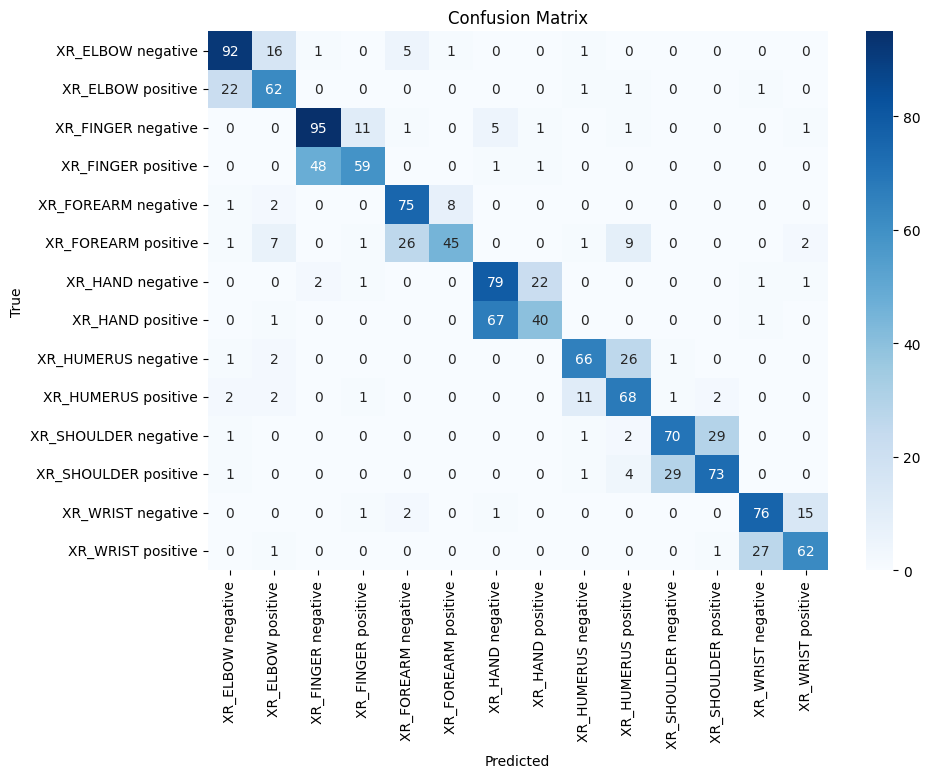

MobileNet model saved to D:\Downloads\MURA-v1.1\MURA-v1.1\mobilenet_model.pth


c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNet model loaded successfully
Predicted class for D:\Downloads\MURA-v1.1\MURA-v1.1\train\XR_FOREARM\patient09309\study1_negative\image2.png: XR_FOREARM negative


In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import pandas as pd

# Base directory for the dataset
BASE_DIR = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1"
df = pd.read_csv(os.path.join(BASE_DIR, "train_image_labeled.csv"))

# Select 500 images per class
df = df.groupby('class_name').sample(n=500, random_state=42).reset_index(drop=True)

# Preprocessing for MobileNet
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, df, base_dir=BASE_DIR):
        self.df = df
        self.base_dir = base_dir
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        relative_path = self.df.iloc[idx, 0]
        image_path = os.path.join(self.base_dir, relative_path.lstrip("MURA-v1.1/"))
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = preprocess_image(image_path)
        label = self.df.iloc[idx, 1]
        return image, label

# Label Encoding
label_map = {label: idx for idx, label in enumerate(np.unique(df['class_name']))}
df['class_name'] = df['class_name'].map(label_map)
reverse_label_map = {idx: label for label, idx in label_map.items()}

# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# DataLoader
train_dataset = ImageDataset(train_df, base_dir=BASE_DIR)
val_dataset = ImageDataset(val_df, base_dir=BASE_DIR)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained MobileNetV2 and modify the classifier
mobilenet = models.mobilenet_v2(pretrained=True)
num_classes = len(label_map)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)  # Replace the final layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Validation function
def validate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Train the model
print("Training MobileNet model...")
train_model(mobilenet, train_loader, criterion, optimizer, num_epochs=10)

# Validate the model
print("Validating MobileNet model...")
val_predictions, val_labels = validate_model(mobilenet, val_loader)

# Classification Report
print(classification_report(val_labels, val_predictions, target_names=[label for label, idx in label_map.items()]))

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[label for label in label_map], yticklabels=[label for label in label_map])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the MobileNet model
model_save_path = os.path.join(BASE_DIR, "mobilenet_model.pth")
torch.save(mobilenet.state_dict(), model_save_path)
print(f"MobileNet model saved to {model_save_path}")

# Load the MobileNet model
loaded_mobilenet = models.mobilenet_v2(pretrained=False)
loaded_mobilenet.classifier[1] = nn.Linear(loaded_mobilenet.last_channel, num_classes)
loaded_mobilenet.load_state_dict(torch.load(model_save_path))
loaded_mobilenet.to(device)
loaded_mobilenet.eval()
print("MobileNet model loaded successfully")

# Single image prediction
def predict_single_image(image_path, model, reverse_label_map):
    image = preprocess_image(image_path)
    image = image.unsqueeze(0)
    
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        _, prediction = torch.max(outputs, 1)
        predicted_label = reverse_label_map[prediction.item()]
    return predicted_label

# Example single image prediction
example_image_path = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1\\train\\XR_FOREARM\\patient09309\\study1_negative\\image2.png"
try:
    predicted_class = predict_single_image(example_image_path, loaded_mobilenet, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Densenet

c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\085/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:02<00:00, 12.6MB/s]


Training DenseNet121 model...
Epoch [1/10], Loss: 1.1510, Train Accuracy: 52.71%
Epoch [2/10], Loss: 0.8217, Train Accuracy: 63.30%
Epoch [3/10], Loss: 0.7532, Train Accuracy: 67.12%
Epoch [4/10], Loss: 0.6817, Train Accuracy: 70.07%
Epoch [5/10], Loss: 0.6436, Train Accuracy: 72.41%
Epoch [6/10], Loss: 0.5826, Train Accuracy: 74.79%
Epoch [7/10], Loss: 0.5422, Train Accuracy: 76.98%
Epoch [8/10], Loss: 0.4897, Train Accuracy: 79.32%
Epoch [9/10], Loss: 0.4650, Train Accuracy: 80.07%
Epoch [10/10], Loss: 0.4230, Train Accuracy: 82.64%
Validating DenseNet121 model...
Validation Accuracy: 69.43%
                      precision    recall  f1-score   support

   XR_ELBOW negative       0.78      0.61      0.69       116
   XR_ELBOW positive       0.56      0.77      0.65        87
  XR_FINGER negative       0.67      0.82      0.74       115
  XR_FINGER positive       0.79      0.58      0.67       109
 XR_FOREARM negative       0.69      0.73      0.71        86
 XR_FOREARM positive      

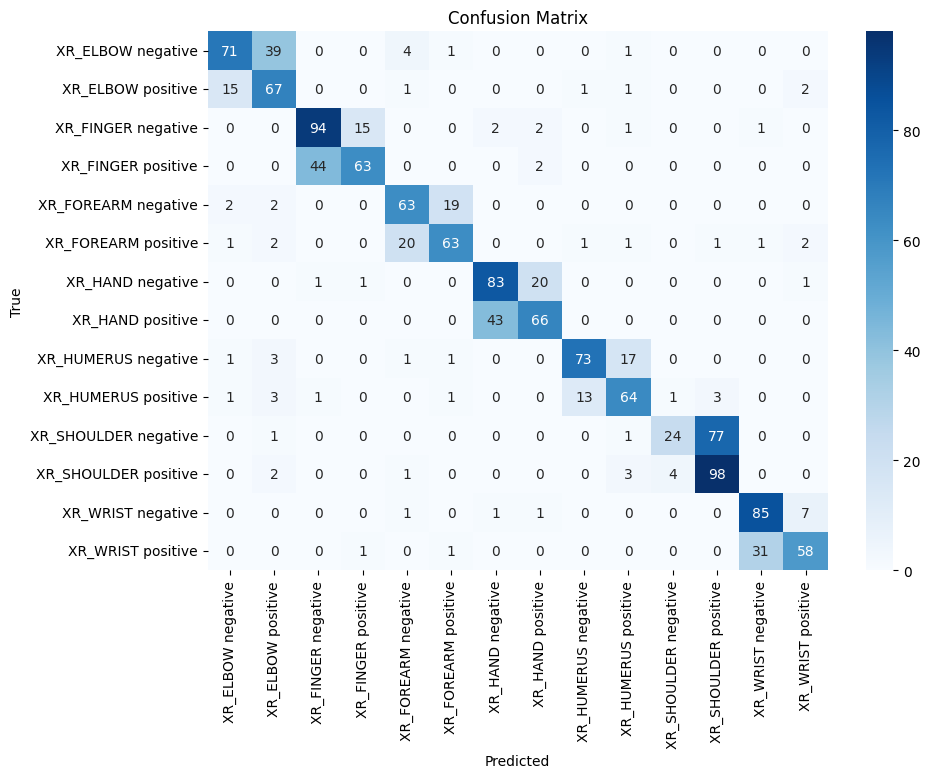

DenseNet model saved to D:\Downloads\MURA-v1.1\MURA-v1.1\densenet_model.pth


c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet model loaded successfully
Predicted class for D:\Downloads\MURA-v1.1\MURA-v1.1\train\XR_FOREARM\patient09309\study1_negative\image2.png: XR_FOREARM negative


In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import pandas as pd

# Base directory for the dataset
BASE_DIR = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1"
df = pd.read_csv(os.path.join(BASE_DIR, "train_image_labeled.csv"))

# Select 500 images per class
df = df.groupby('class_name').sample(n=500, random_state=42).reset_index(drop=True)

# Preprocessing for DenseNet
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, df, base_dir=BASE_DIR):
        self.df = df
        self.base_dir = base_dir
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        relative_path = self.df.iloc[idx, 0]
        image_path = os.path.join(self.base_dir, relative_path.lstrip("MURA-v1.1/"))
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = preprocess_image(image_path)
        label = self.df.iloc[idx, 1]
        return image, label

# Label Encoding
label_map = {label: idx for idx, label in enumerate(np.unique(df['class_name']))}
df['class_name'] = df['class_name'].map(label_map)
reverse_label_map = {idx: label for label, idx in label_map.items()}

# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# DataLoader
train_dataset = ImageDataset(train_df, base_dir=BASE_DIR)
val_dataset = ImageDataset(val_df, base_dir=BASE_DIR)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained DenseNet121 and modify the classifier
densenet = models.densenet121(pretrained=True)
num_classes = len(label_map)
num_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%")

# Validation function with accuracy
def validate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    return np.array(all_preds), np.array(all_labels)

# Train the model
print("Training DenseNet121 model...")
train_model(densenet, train_loader, criterion, optimizer, num_epochs=10)

# Validate the model
print("Validating DenseNet121 model...")
val_predictions, val_labels = validate_model(densenet, val_loader)

# Classification Report
print(classification_report(val_labels, val_predictions, target_names=[label for label, idx in label_map.items()]))

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[label for label in label_map], yticklabels=[label for label in label_map])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the DenseNet model
model_save_path = os.path.join(BASE_DIR, "densenet_model.pth")
torch.save(densenet.state_dict(), model_save_path)
print(f"DenseNet model saved to {model_save_path}")

# Load the DenseNet model
loaded_densenet = models.densenet121(pretrained=False)
loaded_densenet.classifier = nn.Linear(loaded_densenet.classifier.in_features, num_classes)
loaded_densenet.load_state_dict(torch.load(model_save_path))
loaded_densenet.to(device)
loaded_densenet.eval()
print("DenseNet model loaded successfully")

# Single image prediction
def predict_single_image(image_path, model, reverse_label_map):
    image = preprocess_image(image_path)
    image = image.unsqueeze(0)
    
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        _, prediction = torch.max(outputs, 1)
        predicted_label = reverse_label_map[prediction.item()]
    return predicted_label

# Example single image prediction
example_image_path = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1\\train\\XR_FOREARM\\patient09309\\study1_negative\\image2.png"
try:
    predicted_class = predict_single_image(example_image_path, loaded_densenet, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Hybrid model(mobilenet + random forest)

c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting training features to disk...
Processed 32/5600 samples
Processed 64/5600 samples
Processed 96/5600 samples
Processed 128/5600 samples
Processed 160/5600 samples
Processed 192/5600 samples
Processed 224/5600 samples
Processed 256/5600 samples
Processed 288/5600 samples
Processed 320/5600 samples
Processed 352/5600 samples
Processed 384/5600 samples
Processed 416/5600 samples
Processed 448/5600 samples
Processed 480/5600 samples
Processed 512/5600 samples
Processed 544/5600 samples
Processed 576/5600 samples
Processed 608/5600 samples
Processed 640/5600 samples
Processed 672/5600 samples
Processed 704/5600 samples
Processed 736/5600 samples
Processed 768/5600 samples
Processed 800/5600 samples
Processed 832/5600 samples
Processed 864/5600 samples
Processed 896/5600 samples
Processed 928/5600 samples
Processed 960/5600 samples
Processed 992/5600 samples
Processed 1024/5600 samples
Processed 1056/5600 samples
Processed 1088/5600 samples
Processed 1120/5600 samples
Processed 1152

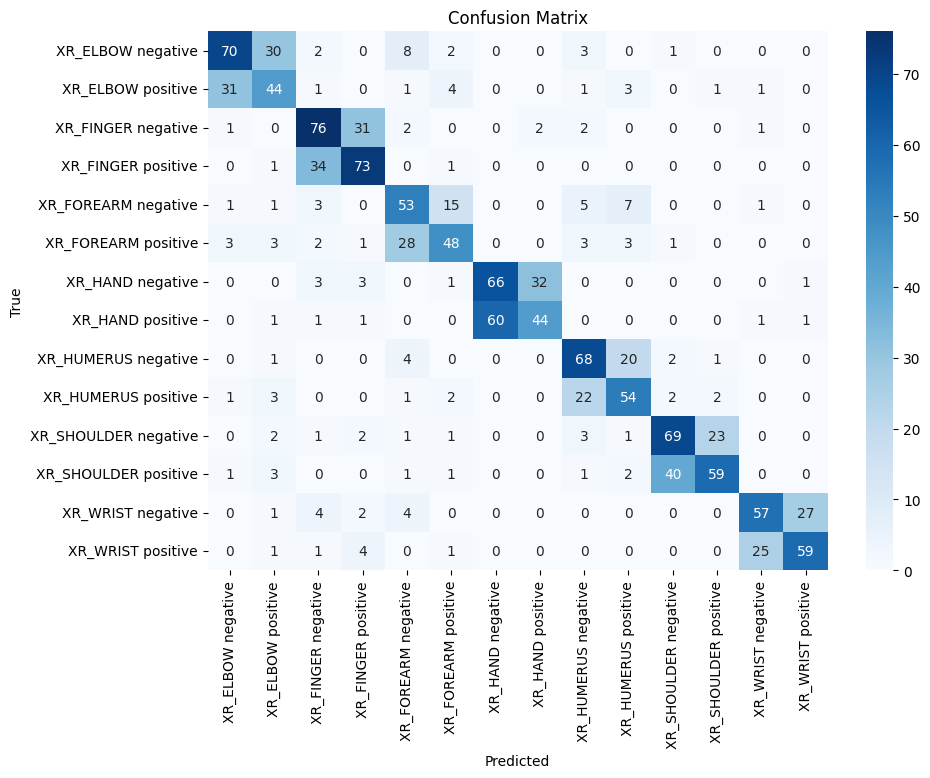

Predicted class for D:\Downloads\MURA-v1.1\MURA-v1.1\train\XR_FOREARM\patient09309\study1_negative\image2.png: XR_FOREARM negative


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import pandas as pd
import joblib
import h5py

# Base directory for the dataset
BASE_DIR = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1"
df = pd.read_csv(os.path.join(BASE_DIR, "train_image_labeled.csv"))

# Select 500 images per class
df = df.groupby('class_name').sample(n=500, random_state=42).reset_index(drop=True)

# Preprocessing for MobileNet
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, df, base_dir=BASE_DIR):
        self.df = df
        self.base_dir = base_dir
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        relative_path = self.df.iloc[idx, 0]
        image_path = os.path.join(self.base_dir, relative_path.lstrip("MURA-v1.1/"))
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = preprocess_image(image_path)
        label = self.df.iloc[idx, 1]
        return image, label

# Label Encoding
label_map = {label: idx for idx, label in enumerate(np.unique(df['class_name']))}
df['class_name'] = df['class_name'].map(label_map)
reverse_label_map = {idx: label for label, idx in label_map.items()}

# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# DataLoader
train_dataset = ImageDataset(train_df, base_dir=BASE_DIR)
val_dataset = ImageDataset(val_df, base_dir=BASE_DIR)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])  # Remove classifier
mobilenet.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet.to(device)

# Feature extraction with disk storage
def extract_features_to_disk(loader, model, output_file):
    with h5py.File(output_file, 'w') as h5f:
        num_samples = len(loader.dataset)
        feature_size = 1280 * 7 * 7  # MobileNetV2 feature size
        features_dset = h5f.create_dataset('features', (num_samples, feature_size), dtype='float32')
        labels_dset = h5f.create_dataset('labels', (num_samples,), dtype='int64')
        
        start_idx = 0
        with torch.no_grad():
            for images, lbls in loader:
                images = images.to(device)
                outputs = model(images)
                outputs = outputs.view(outputs.size(0), -1).cpu().numpy()
                batch_size = outputs.shape[0]
                
                features_dset[start_idx:start_idx + batch_size] = outputs
                labels_dset[start_idx:start_idx + batch_size] = lbls.numpy()
                start_idx += batch_size
                print(f"Processed {start_idx}/{num_samples} samples")

# Extract and save features
print("Extracting training features to disk...")
train_features_file = os.path.join(BASE_DIR, "train_features.h5")
extract_features_to_disk(train_loader, mobilenet, train_features_file)

print("Extracting validation features to disk...")
val_features_file = os.path.join(BASE_DIR, "val_features.h5")
extract_features_to_disk(val_loader, mobilenet, val_features_file)

# Load features from disk
def load_features_from_disk(file_path):
    with h5py.File(file_path, 'r') as h5f:
        features = h5f['features'][:]
        labels = h5f['labels'][:]
    return features, labels

# Load training and validation features
print("Loading training features...")
train_features, train_labels = load_features_from_disk(train_features_file)
print("Loading validation features...")
val_features, val_labels = load_features_from_disk(val_features_file)

# Train Random Forest classifier
print("Training Random Forest classifier...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(train_features, train_labels)

# Save the Random Forest model
model_save_path = os.path.join(BASE_DIR, "rf_model.joblib")
joblib.dump(rf, model_save_path)
print(f"Random Forest model saved to {model_save_path}")

# Load the Random Forest model
loaded_rf = joblib.load(model_save_path)
print("Random Forest model loaded successfully")

# Validate with accuracy
val_predictions = loaded_rf.predict(val_features)
correct = np.sum(val_predictions == val_labels)
total = len(val_labels)
val_accuracy = 100 * correct / total
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(classification_report(val_labels, val_predictions, target_names=[label for label, idx in label_map.items()]))

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[label for label in label_map], yticklabels=[label for label in label_map])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Single image prediction
def predict_single_image(image_path, mobilenet_model, rf_model, reverse_label_map):
    image = preprocess_image(image_path)
    image = image.unsqueeze(0)
    
    mobilenet_model.to(device)
    image = image.to(device)
    with torch.no_grad():
        features = mobilenet_model(image)
        features = features.view(features.size(0), -1).cpu().numpy()
    
    prediction = rf_model.predict(features)
    predicted_label = reverse_label_map[prediction[0]]
    return predicted_label

# Example single image prediction
example_image_path = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1\\train\\XR_FOREARM\\patient09309\\study1_negative\\image2.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_rf, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)

Class distribution in the dataset:
class_name
XR_ELBOW negative       500
XR_ELBOW positive       500
XR_FINGER negative      500
XR_FINGER positive      500
XR_FOREARM negative     500
XR_FOREARM positive     500
XR_HAND negative        500
XR_HAND positive        500
XR_HUMERUS negative     500
XR_HUMERUS positive     500
XR_SHOULDER negative    500
XR_SHOULDER positive    500
XR_WRIST negative       500
XR_WRIST positive       500
Name: count, dtype: int64
Dataset is already balanced.
Extracting training features to disk...


c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\085\.conda\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processed 32/5600 samples
Processed 64/5600 samples
Processed 96/5600 samples
Processed 128/5600 samples
Processed 160/5600 samples
Processed 192/5600 samples
Processed 224/5600 samples
Processed 256/5600 samples
Processed 288/5600 samples
Processed 320/5600 samples
Processed 352/5600 samples
Processed 384/5600 samples
Processed 416/5600 samples
Processed 448/5600 samples
Processed 480/5600 samples
Processed 512/5600 samples
Processed 544/5600 samples
Processed 576/5600 samples
Processed 608/5600 samples
Processed 640/5600 samples
Processed 672/5600 samples
Processed 704/5600 samples
Processed 736/5600 samples
Processed 768/5600 samples
Processed 800/5600 samples
Processed 832/5600 samples
Processed 864/5600 samples
Processed 896/5600 samples
Processed 928/5600 samples
Processed 960/5600 samples
Processed 992/5600 samples
Processed 1024/5600 samples
Processed 1056/5600 samples
Processed 1088/5600 samples
Processed 1120/5600 samples
Processed 1152/5600 samples
Processed 1184/5600 sample

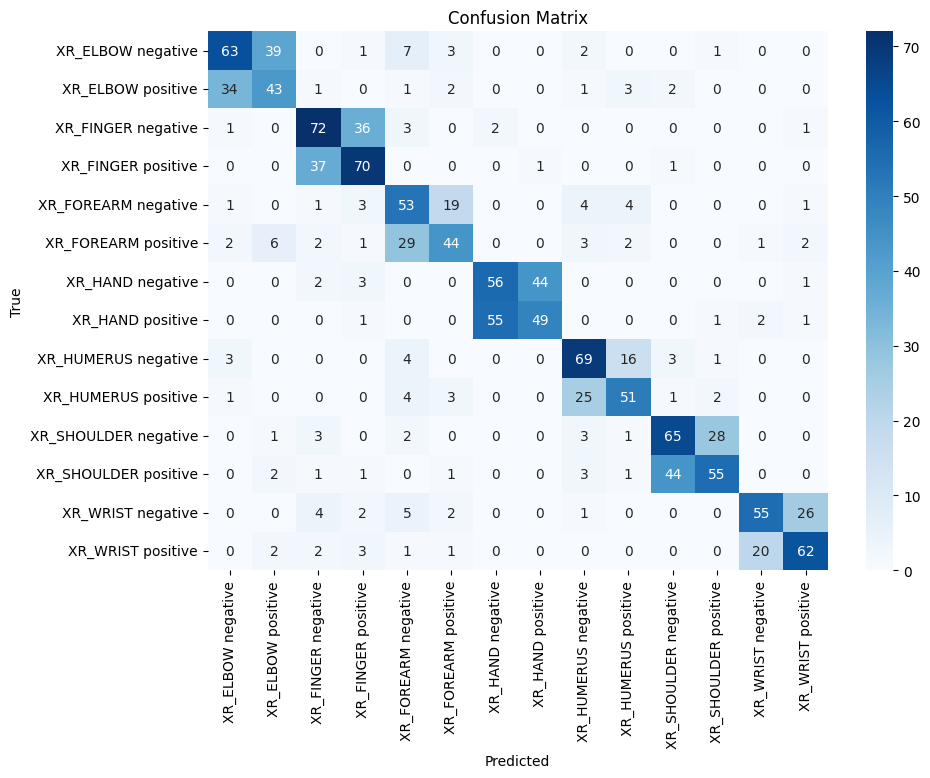

Predicted class for D:\Downloads\MURA-v1.1\MURA-v1.1\train\XR_FOREARM\patient09309\study1_negative\image2.png: XR_FOREARM negative


In [93]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import pandas as pd
import joblib
import h5py

# Base directory for the dataset
BASE_DIR = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1"

# Load the dataset
df = pd.read_csv(os.path.join(BASE_DIR, "train_image_labeled.csv"))

# Select up to 500 images per class
df = df.groupby('class_name').sample(n=500, random_state=42, replace=False).reset_index(drop=True)

# Check class distribution
print("Class distribution in the dataset:")
print(df['class_name'].value_counts())

# Balance the dataset if needed
min_samples = df['class_name'].value_counts().min()
if df['class_name'].value_counts().nunique() != 1:  # Check if counts are unequal
    print(f"Dataset is unbalanced. Balancing to {min_samples} samples per class...")
    df = df.groupby('class_name').sample(n=min_samples, random_state=42).reset_index(drop=True)
    print("Class distribution after balancing:")
    print(df['class_name'].value_counts())
else:
    print("Dataset is already balanced.")

# Preprocessing for MobileNet
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, df, base_dir=BASE_DIR):
        self.df = df
        self.base_dir = base_dir
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        relative_path = self.df.iloc[idx, 0]
        image_path = os.path.join(self.base_dir, relative_path.lstrip("MURA-v1.1/"))
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
        image = preprocess_image(image_path)
        label = self.df.iloc[idx, 1]
        return image, label

# Label Encoding
label_map = {label: idx for idx, label in enumerate(np.unique(df['class_name']))}
df['class_name'] = df['class_name'].map(label_map)
reverse_label_map = {idx: label for label, idx in label_map.items()}

# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# DataLoader
train_dataset = ImageDataset(train_df, base_dir=BASE_DIR)
val_dataset = ImageDataset(val_df, base_dir=BASE_DIR)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])  # Remove classifier
mobilenet.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet.to(device)

# Feature extraction with disk storage
def extract_features_to_disk(loader, model, output_file):
    with h5py.File(output_file, 'w') as h5f:
        num_samples = len(loader.dataset)
        feature_size = 1280 * 7 * 7  # MobileNetV2 feature size
        features_dset = h5f.create_dataset('features', (num_samples, feature_size), dtype='float32')
        labels_dset = h5f.create_dataset('labels', (num_samples,), dtype='int64')
        
        start_idx = 0
        with torch.no_grad():
            for images, lbls in loader:
                images = images.to(device)
                outputs = model(images)
                outputs = outputs.view(outputs.size(0), -1).cpu().numpy()
                batch_size = outputs.shape[0]
                
                features_dset[start_idx:start_idx + batch_size] = outputs
                labels_dset[start_idx:start_idx + batch_size] = lbls.numpy()
                start_idx += batch_size
                print(f"Processed {start_idx}/{num_samples} samples")

# Extract and save features
print("Extracting training features to disk...")
train_features_file = os.path.join(BASE_DIR, "train_features.h5")
extract_features_to_disk(train_loader, mobilenet, train_features_file)

print("Extracting validation features to disk...")
val_features_file = os.path.join(BASE_DIR, "val_features.h5")
extract_features_to_disk(val_loader, mobilenet, val_features_file)

# Load features from disk
def load_features_from_disk(file_path):
    with h5py.File(file_path, 'r') as h5f:
        features = h5f['features'][:]
        labels = h5f['labels'][:]
    return features, labels

# Load training and validation features
print("Loading training features...")
train_features, train_labels = load_features_from_disk(train_features_file)
print("Loading validation features...")
val_features, val_labels = load_features_from_disk(val_features_file)

# Train Random Forest classifier
print("Training Random Forest classifier...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(train_features, train_labels)

# Save the Random Forest model
model_save_path = os.path.join(BASE_DIR, "rf_model.joblib")
joblib.dump(rf, model_save_path)
print(f"Random Forest model saved to {model_save_path}")

# Load the Random Forest model
loaded_rf = joblib.load(model_save_path)
print("Random Forest model loaded successfully")

# Validate with accuracy
val_predictions = loaded_rf.predict(val_features)
correct = np.sum(val_predictions == val_labels)
total = len(val_labels)
val_accuracy = 100 * correct / total
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(classification_report(val_labels, val_predictions, target_names=[label for label, idx in label_map.items()]))

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[label for label in label_map], yticklabels=[label for label in label_map])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Single image prediction
def predict_single_image(image_path, mobilenet_model, rf_model, reverse_label_map):
    image = preprocess_image(image_path)
    image = image.unsqueeze(0)
    
    mobilenet_model.to(device)
    image = image.to(device)
    with torch.no_grad():
        features = mobilenet_model(image)
        features = features.view(features.size(0), -1).cpu().numpy()
    
    prediction = rf_model.predict(features)
    predicted_label = reverse_label_map[prediction[0]]
    return predicted_label

# Example single image prediction
example_image_path = "D:\\Downloads\\MURA-v1.1\\MURA-v1.1\\train\\XR_FOREARM\\patient09309\\study1_negative\\image2.png"
try:
    predicted_class = predict_single_image(example_image_path, mobilenet, loaded_rf, reverse_label_map)
    print(f"Predicted class for {example_image_path}: {predicted_class}")
except FileNotFoundError as e:
    print(e)